cross match Claire's NSA subsample with other columns in the parent NSA catalog

In [16]:
import h5py
import numpy as np
from astropy.io import fits
from astropy.cosmology import WMAP7
# -- iQuench -- 
from letstalkaboutquench import util as UT

Read in Claire's low mass central (isolated) catalog

In [2]:
f_claire = ''.join([UT.dat_dir(), 'dickey_NSA_iso_lowmass_gals.txt'])
claire = np.loadtxt(f_claire, unpack=True, skiprows=1) # columns: NSAID MASS DHOST D4000 HAEW HALPHA_SFR HALPHA_SSFR

In [3]:
n_claire = len(claire[0])
print('Claires same has %i galaxies' % n_claire)

Claires same has 14998 galaxies


Read in NSA parent catalog

In [4]:
f_nsa = fits.open(''.join([UT.dat_dir(), 'nsa_v0_1_2.fits']))
nsa_data = f_nsa[1].data

In [5]:
n_nsa = len(nsa_data.field('RA'))
print('%i galaxies' % n_nsa)
print(nsa_data.names)

145155 galaxies
['IAUNAME', 'SUBDIR', 'RA', 'DEC', 'ISDSS', 'INED', 'ISIXDF', 'IALFALFA', 'IZCAT', 'ITWODF', 'MAG', 'Z', 'ZSRC', 'SIZE', 'RUN', 'CAMCOL', 'FIELD', 'RERUN', 'XPOS', 'YPOS', 'ZLG', 'ZDIST', 'ZDIST_ERR', 'NSAID', 'NMGY', 'NMGY_IVAR', 'OK', 'RNMGY', 'ABSMAG', 'AMIVAR', 'EXTINCTION', 'KCORRECT', 'KCOEFF', 'MTOL', 'B300', 'B1000', 'METS', 'MASS', 'XCEN', 'YCEN', 'NPROF', 'PROFMEAN', 'PROFMEAN_IVAR', 'QSTOKES', 'USTOKES', 'BASTOKES', 'PHISTOKES', 'PETROFLUX', 'PETROFLUX_IVAR', 'FIBERFLUX', 'FIBERFLUX_IVAR', 'BA50', 'PHI50', 'BA90', 'PHI90', 'SERSICFLUX', 'SERSICFLUX_IVAR', 'SERSIC_N', 'SERSIC_BA', 'SERSIC_PHI', 'ASYMMETRY', 'CLUMPY', 'DFLAGS', 'AID', 'PID', 'DVERSION', 'PROFTHETA', 'PETROTHETA', 'PETROTH50', 'PETROTH90', 'SERSIC_TH50', 'OBJNO', 'PLATE', 'FIBERID', 'MJD', 'COEFF', 'VDISP', 'D4000', 'D4000ERR', 'FA', 'FAERR', 'S2FLUX', 'S2FLUXERR', 'S2EW', 'S2EWERR', 'S2VMEAS', 'S2VMERR', 'S2RATIO', 'HAFLUX', 'HAFLUXERR', 'HAEW', 'HAEWERR', 'HAVMEAS', 'HAVMERR', 'N2FLUX', 'N2FLU

In [7]:
m_nsa = [] 
for i in range(n_claire): 
    match = (claire[0][i] == nsa_data.field("NSAID")) 
    if np.sum(match) > 1: 
        raise ValueError
    m_nsa.append(np.arange(n_nsa)[match])
m_nsa = np.array(m_nsa)
m_nsa = m_nsa.flatten()

Now lets compute UV SFRs for Claire's galaxies

In [25]:
# some useful functions
def jansky(flux,kcorrect):
    '''Getting fluxes in Janskies from Nanomaggies:
    Inputs: Choose Petrosian/Sersic Nmgy and the relevant Kcorrection
    '''
    flux_in_Jy = flux*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return flux_in_Jy


def UVsfr(z,fmag,nmag,rmag,f_flux):
    ''' Calculate UV star formation rates. 
    Inputs: NSAID, z, F-band magnitude, N-band magnitude, r-band magnitude, F-band flux in Janskies
    '''
    fn = fmag - nmag
    opt = nmag - rmag   # N-r
    
    #Luminosity Distance
    dist = WMAP7.comoving_distance(z)
    ldist = (1+z)*dist.value
    
    #calculating Attenuation 'atten'
    atten = np.repeat(-999., len(fmag)) 

    case1 = np.where((opt > 4.) & (fn < 0.95))
    atten[case1] = 3.32*fn[case1] + 0.22
    case2 = np.where((opt > 4.) & (fn >= 0.95))
    atten[case2] = 3.37
    case3 = np.where((opt <= 4.) & (fn < 0.9))
    atten[case3] = 2.99*fn[case3] + 0.27
    case4 = np.where((opt <= 4.) & (fn >= 0.9))
    atten[case4] = 2.96

    #if opt >= 4.0:
    #    if fn < 0.95:
    #        atten = 3.32*fn + 0.22
    #    else:
    #        atten = 3.37
    #else:
    #    if fn < 0.90:
    #        atten = 2.99*fn +0.27
    #    else:
    #        atten = 2.96

    lum = 4.*np.pi*(ldist**2.0)*(3.087**2.0)*(10**(25.0 +(atten/2.5)))*f_flux  #Luminosity
    sfr = 1.08*(10**(-28.0))*np.abs(lum)
    return sfr

In [26]:
nsa_fuv = nsa_data.field('NMGY')[:,0] # nanomaggies
nsa_fuv_kcorr = nsa_data.field('KCORRECT')[:,0] # kcorrect
nsa_fuv_jansky = jansky(nsa_fuv, nsa_fuv_kcorr)

nsa_uv_sfr = UVsfr(nsa_data.field('z'), 
                   nsa_data.field('ABSMAG')[:,0], 
                   nsa_data.field('ABSMAG')[:,1], 
                   nsa_data.field('ABSMAG')[:,4], 
                   nsa_fuv_jansky) 

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-2.0, 1.0)

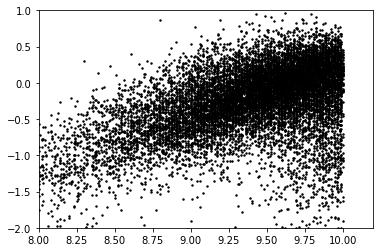

In [29]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(claire[1], np.log10(nsa_uv_sfr[m_nsa]), c='k', s=2)
sub.set_xlim([8., 10.2])
sub.set_ylim([-2., 1.])

In [30]:
cols_claire = ['NSAID', 'MASS', 'DHOST', 'D4000', 'HAEW', 'HALPHA_SFR', 'HALPHA_SSFR']

f = h5py.File(''.join([UT.dat_dir(), 'dickey_NSA_iso_lowmass_gals.hdf5']), 'w')
# add in claire's data first
for i_col, col in enumerate(cols_claire): 
    f.create_dataset(col, data=claire[i_col])

for name in nsa_data.names:
    if name in cols_claire: 
        print('name = %s' % name)
        continue
    f.create_dataset(name, data=nsa_data.field(name)[m_nsa])
f.create_dataset('UVSFR', data=nsa_uv_sfr[m_nsa])
f.close()

name = NSAID
name = MASS
name = D4000
name = HAEW


also create light weight text file

In [36]:
f_update = ''.join([UT.dat_dir(), 'dickey_NSA_iso_lowmass_gals_uvsfr.txt'])
updata = np.array([claire[0], claire[1], claire[2], claire[3], claire[4], claire[5], claire[6], nsa_uv_sfr[m_nsa]])
# columns: NSAID MASS DHOST D4000 HAEW HALPHA_SFR HALPHA_SSFR UV_SFR
np.savetxt(f_update, updata.T, fmt='%i %f %f %f %f %f %f %f', header="columns: NSAID MASS DHOST D4000 HAEW HALPHA_SFR HALPHA_SSFR UV_SFR")